In [ ]:
'''
This script fits randomly generated simulated proton tracks with Monte-Carlo method.
'''

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pytpc
from pytpc.constants import *
import pytpc.simulation
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import yaml
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)

In [4]:
tilt = config['tilt'] * degrees 
padplane = mcfitter.padplane
efield = np.array(config['efield'])
bfield = np.array(config['bfield'])
mass_num = config['mass_num']
charge_num = config['charge_num']
gas = pytpc.gases.InterpolatedGas(config['gas_name'], config['gas_pressure'])
beam_enu0 = config['beam_enu0']
beam_charge = config['beam_charge']
beam_mass = config['beam_mass']
max_en = config['tracker_max_en']
vd = np.array(config['vd'])
max_beam_angle = config['max_beam_angle']*degrees
beam_origin_z = config['beam_origin_z']

In [5]:
sim = EventSimulator(config)

In [6]:
#randomly generation of events
num_evts = 100
pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle, beam_origin_z, gas, num_evts)


In [63]:
p = next(pgen)
print(p)

(array([-5.70868843e-03,  1.18016550e-02,  2.10109076e-01,  1.77881423e+00,
        6.26158737e+00,  2.75173048e+00]), array([-0.00613848,  0.01269018, -0.99990063]))


In [64]:
evtRandom, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])
pyevtRandom = sim.convert_event(evtRandom)
Random_xyzs = pyevtRandom.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)


In [65]:
Random_xy = Random_xyzs[:, 0:2]
Random_xy_C = np.ascontiguousarray(Random_xy, dtype=np.double)
Random_cx, Random_cy = pytpc.cleaning.hough_circle(Random_xy_C)
#The center of curvature of the track, in mm.
Random_uvw, (Random_cu, Random_cv) = mcfitter.preprocess(Random_xyzs[:, 0:5], center=(Random_cx, Random_cy), rotate_pads=True, drop_beampads=True)
Random_uvw_values = Random_uvw.values
print(Random_cu, Random_cv)
#MC fitting
Random_mcres, Random_minChis, Random_all_params, Random_good_param_idx = mcfitter.process_event(Random_uvw, Random_cu, Random_cv, return_details=True)
print(Random_mcres)

3.9263448847660527 -15.572786953927022
{'x0': -0.004559409282081725, 'y0': 0.012040409914183398, 'z0': 0.23064100993572823, 'enu0': 2.546662027191671, 'azi0': -0.08866784675702569, 'pol0': 2.8007980788201015, 'posChi2': 4.09287561746156, 'enChi2': 1.469532881452785, 'vertChi2': 3.3151936780619766, 'lin_scat_ang': 0.37145689355177813, 'lin_beam_int': 199.41278841866475, 'lin_chi2': 18.233904444868628, 'rad_curv': 27.385513572407216, 'brho': 0.12675217857258758, 'curv_en': 0.7694731698480155, 'curv_ctr_x': 3.9263448847660527, 'curv_ctr_y': -15.572786953927022}


In [66]:
evtClean, ctr = sim.make_event(Random_mcres['x0'], Random_mcres['y0'], Random_mcres['z0'], Random_mcres['enu0'], Random_mcres['azi0'], Random_mcres['pol0'])
#evtClean, ctr = sim.make_event(p[0][0], p[0][1], p[0][2], p[0][3], p[0][4], p[0][5])

pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)


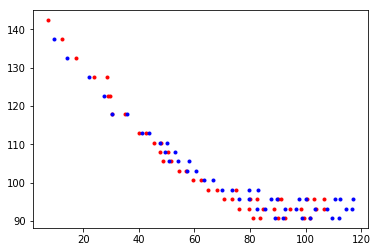

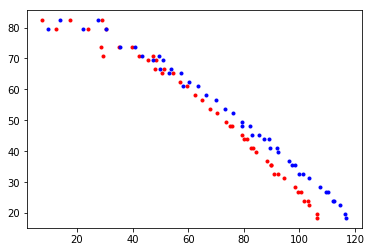

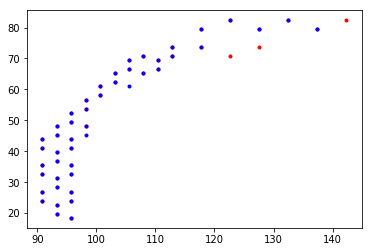

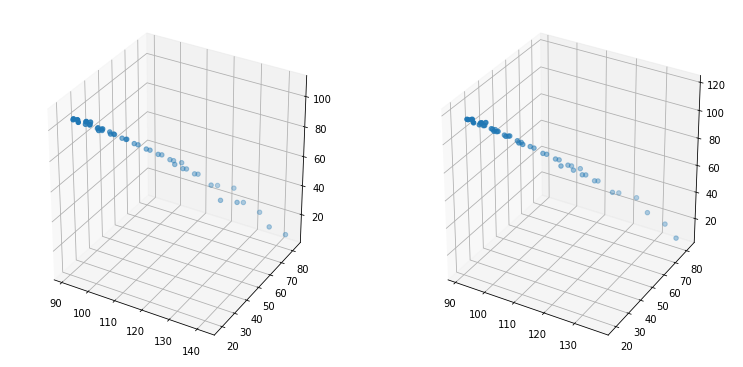

In [67]:
plt.plot(Random_xyzs[:, 2], Random_xyzs[:, 0], 'r.')
plt.plot(sim_xyzs[:, 2], sim_xyzs[:, 0], 'b.')
plt.show()
plt.plot(Random_xyzs[:, 2], Random_xyzs[:, 1], 'r.')
plt.plot(sim_xyzs[:, 2], sim_xyzs[:, 1], 'b.')
plt.show()
plt.plot(Random_xyzs[:, 0], Random_xyzs[:, 1], 'r.')
plt.plot(sim_xyzs[:, 0], sim_xyzs[:, 1], 'b.')
plt.show()



fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(Random_xyzs[:,0],Random_xyzs[:,1],Random_xyzs[:,2])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_xyzs[:,0],sim_xyzs[:,1],sim_xyzs[:,2])